In [25]:
import numpy as np
from gurobipy import Model,GRB

In [26]:
# u_j
p_utility = np.array([26,65,35,48,26,53,32,48,58,62])

# w_j
p_weight = np.array([27,28,16,28,24,25,19,23,29,29])

#  Gamma
p_gamma = 1.5

# C
p_capacity = 120

In [27]:
n_item = p_utility.shape[0]

In [28]:
s_item = range(n_item)

In [29]:
model = Model("robust_knapsack")

In [30]:
# x_j
v_select = model.addVars(n_item,vtype=GRB.BINARY)

# p_j
v_dual_p = model.addVars(n_item)

# y_j
v_dual_y = model.addVars(n_item)

# z
v_dual_z = model.addVar()

In [31]:
# w_hat_j
p_weight_hat = p_weight*.1
print(p_weight_hat)

[2.7 2.8 1.6 2.8 2.4 2.5 1.9 2.3 2.9 2.9]


In [32]:
model.setObjective( sum( v_select[j]*p_utility[j] for j in s_item), GRB.MAXIMIZE)

In [33]:
model.addConstr( sum(v_select[j]*p_weight[j] for j in s_item) +
                p_gamma*v_dual_z + sum(v_dual_p[j] for j in s_item) <= p_capacity)

<gurobi.Constr *Awaiting Model Update*>

In [34]:
for j in s_item:
    model.addConstr(v_dual_p[j] + v_dual_z >= p_weight_hat[j]*v_dual_y[j])

In [35]:
for j in s_item:
    model.addConstr(v_select[j] >= -1*v_dual_y[j])
    model.addConstr(v_select[j] <= v_dual_y[j])

In [36]:
model.optimize()
status = model.status
if status == GRB.OPTIMAL:
    print("objective = ", model.objVal)
    print(model.getAttr('X',v_select))

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 31 rows, 31 columns and 91 nonzeros
Model fingerprint: 0x57cc46b3
Variable types: 21 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [3e+01, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+02, 1e+02]
Found heuristic solution: objective -0.0000000
Presolve removed 20 rows and 10 columns
Presolve time: 0.00s
Presolved: 11 rows, 21 columns, 51 nonzeros
Found heuristic solution: objective 242.0000000
Variable types: 11 continuous, 10 integer (10 binary)

Root relaxation: objective 2.522674e+02, 6 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap |

In [19]:
p_utility = np.array([26,65,35,48,26,53,32,48,58,62])
p_weight = np.array([27,28,16,28,24,25,19,23,29,29])
p_gamma = 2
p_capacity = 120
n_item = p_utility.shape[0]
s_item = range(n_item)
model = Model("robust_knapsack")
v_select = model.addVars(n_item,vtype=GRB.BINARY)
v_dual_p = model.addVars(n_item)
v_dual_y = model.addVars(n_item)
v_dual_z = model.addVar()
p_weight_hat = p_weight*.1
model.setObjective( sum( v_select[j]*p_utility[j] for j in s_item), GRB.MAXIMIZE)
for j in s_item:
    model.addConstr(v_dual_p[j] + v_dual_z >= p_weight_hat[j]*v_dual_y[j])
for j in s_item:
    model.addConstr(v_select[j] >= -1*v_dual_y[j])
    model.addConstr(v_select[j] <= v_dual_y[j])

In [20]:
p_gamma_vec = np.arange(0,n_item,.5).tolist()
obj_vec = np.zeros(len(p_gamma_vec))
model.setParam('OutputFlag',0)
violation_perc = 0

In [23]:
for g in range(len(p_gamma_vec)):
    model.addConstr( sum(v_select[j]*p_weight[j] for j in s_item) +
                p_gamma_vec[g]*v_dual_z + sum(v_dual_p[j] for j in s_item) 
                    <= p_capacity,'cap_constr')
    model.optimize()
    v_select_robust = np.array([v_select[s].X for s in s_item]).astype(int)
    lhs_determ = np.sum(v_select_robust*p_weight)
    if lhs_determ - p_capacity < 0:
        violated = ''
        violation_perc = (p_capacity-lhs_determ)*100/p_capacity
    else:
        violation_perc = 0
        violated = 'not'
    print("Gamma = ",p_gamma_vec[g],": constraints are",violated,
          "violated and violation perc = ",violation_perc)
    obj_vec[g] = model.objVal
    model.remove(model.getConstrByName('cap_constr'))
    model.update()

Gamma =  0.0 : constraints are not violated and violation perc =  0
Gamma =  0.5 : constraints are  violated and violation perc =  2.5
Gamma =  1.0 : constraints are  violated and violation perc =  2.5
Gamma =  1.5 : constraints are  violated and violation perc =  4.166666666666667
Gamma =  2.0 : constraints are  violated and violation perc =  7.5
Gamma =  2.5 : constraints are  violated and violation perc =  7.5
Gamma =  3.0 : constraints are  violated and violation perc =  7.5
Gamma =  3.5 : constraints are  violated and violation perc =  9.166666666666666
Gamma =  4.0 : constraints are  violated and violation perc =  9.166666666666666
Gamma =  4.5 : constraints are  violated and violation perc =  9.166666666666666
Gamma =  5.0 : constraints are  violated and violation perc =  9.166666666666666
Gamma =  5.5 : constraints are  violated and violation perc =  9.166666666666666
Gamma =  6.0 : constraints are  violated and violation perc =  9.166666666666666
Gamma =  6.5 : constraints are

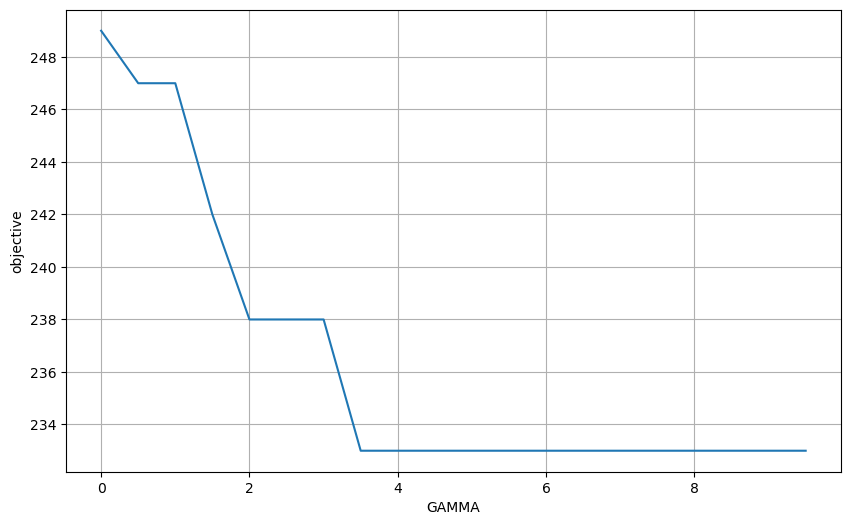

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(p_gamma_vec,obj_vec)
plt.ylabel("objective")
plt.xlabel("GAMMA")
plt.grid()
fig.set_size_inches(10,6)
plt.show()

In [37]:
v_select_robust = np.array([v_select[s].X for s in s_item]).astype(int)
print(v_select_robust)

[0 1 1 0 0 0 1 1 0 1]


In [38]:
perturb_vec = v_select_robust*p_weight_hat

In [39]:
perturb_vec

array([0. , 2.8, 1.6, 0. , 0. , 0. , 1.9, 2.3, 0. , 2.9])

In [40]:
np.argsort(perturb_vec)

array([0, 3, 4, 5, 8, 2, 6, 7, 1, 9], dtype=int64)

In [41]:
import numpy as np

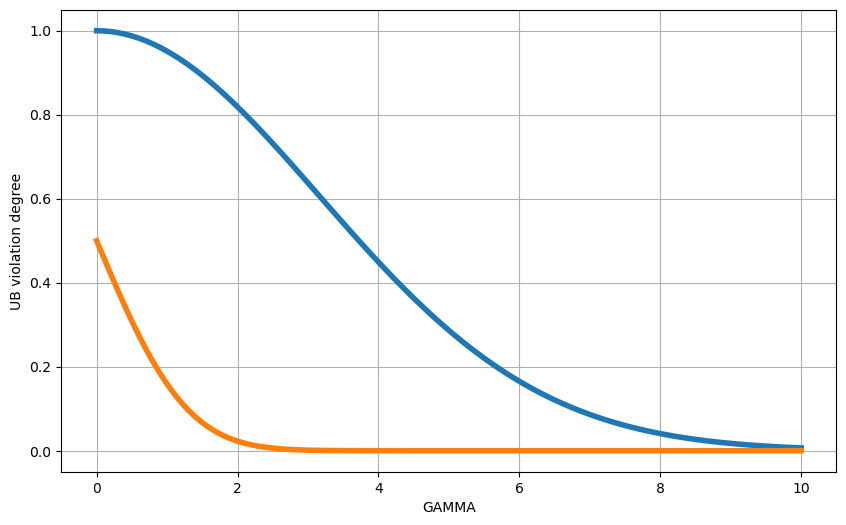

In [43]:
gamma = np.arange(0,n_item+.1,.1)
bound1 = np.exp(-gamma**2/(2*n_item))

import scipy as sp
bound2 = 1 - sp.stats.norm.cdf(gamma)

fig = plt.figure()
plt.plot(gamma,bound1,'-',label="bound 1", linewidth=4)
plt.plot(gamma,bound2,'-',label="bound 2", linewidth=4)

plt.ylabel("UB violation degree")
plt.xlabel("GAMMA")
plt.grid()
fig.set_size_inches(10,6)
plt.show()

In [45]:
np.interp(.05,bound2[::-1],gamma[::-1])

1.6468963447329423